In [173]:
import numpy as np
import mmh3
import os
import pandas as pd
import matplotlib.pyplot as plt

## Functions

In [174]:
def shingle(aString, q, delimiter=' '):
    """
    Input:
        - aString (str): string to split into shingles
        - q (int)
        - delimiter (str): string of the delimiter to consider to split the input string (default: space)
    Return: list of unique shingles
    """
    
    all_shingles = []
    if delimiter != '':
        words_list = aString.split(delimiter)
    else:
        words_list = aString
    if len(words_list) < q:
        q = len(words_list)
    for i in range (len(words_list)-q+1):
        all_shingles.append(delimiter.join(words_list[i:i+q]))
    return list(set(all_shingles))

def listhash(l,seed):
    val = 0
    for e in l:
        val = val ^ mmh3.hash(e, seed)
    return val 

def minhash(shingles_list, seed):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - seed (int): seed for listhash function
    Return: minhash of given shingles
    """
    minhash_value = np.inf
    for aShingle in shingles_list:
        hashcode = listhash([aShingle], seed)
        if minhash_value == None or hashcode < minhash_value:
            minhash_value = hashcode
    return minhash_value

def minhash2(shingles_list, k):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - k (int): seed for listhash function
    Return: sequence of k minhashes
    """
    all_minhash = []
    for i in range(k):
        all_minhash.append(minhash(shingles_list, i))
    return all_minhash

def signature(df_reviews, q = 3, num_hashes = 100):
    """
    Input:
        - dict_docs (dict of str:str): dictionary of {title:document}
        - q (int)
        - num_hashes (int)
    Return: dictionary consisting of document idâ€™s as keys and signatures as values
    """
    dict_signatures = {}
    total_texts = len(df_reviews.index)
    counter = 1
    for ix, text in enumerate(df_reviews['Clean_Review']):
        #print(f'{counter}/{total_texts} - {ix} - Processing...')
        doc_shingles = shingle(text, q)
        minhash_values = minhash2(doc_shingles, num_hashes)
        dict_signatures[ix] = minhash_values
        counter += 1
    return dict_signatures

def jaccard(name1, name2, signatures_dict):
    """
    Input:
        - name1 (str): key of the first document S
        - name2 (str): key of the second document T
        - signatures_dict (dict of str:list): dictionary of signatures
    Return: Jaccard similarity between S and T
    """
    signatures_doc1 = np.array(signatures_dict[name1])
    signatures_doc2 = np.array(signatures_dict[name2])
    return len(np.intersect1d(signatures_doc1, signatures_doc2))/len(np.union1d(signatures_doc1, signatures_doc2))

def lsh(signatures_dict, jaccard_threshold=0.6, seed=42):
    lsh_dict = {}
    for key, values in signatures_dict.items():
        blocks = np.split(np.array(values), b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range (len(list_keys)-1):
        print(i)
        for j in range (i+1, len(list_keys)):
            common_values = np.intersect1d(lsh_dict[list_keys[i]], lsh_dict[list_keys[j]])
            if len(common_values) > 0:
                # we found a candidate
                similarity_score = jaccard(list_keys[i], list_keys[j], signatures_dict)
                if similarity_score >= jaccard_threshold:
                    similar_items[(list_keys[i], list_keys[j])] = similarity_score
                    #print((list_keys[i], list_keys[j]))
                    #print(similar_items[(list_keys[i], list_keys[j])])
    return similar_items

## Import data

In [175]:
root = os.getcwd()
df = pd.read_csv(root + "\clean_sample_data.csv")

In [176]:
df.head()

,overall,reviewText,Clean_Review
0,1.0,Poorest operating system Microsoft ever made. ...,poor operating system microsoft ever make long...
1,1.0,"Currently using Quicken version 2006, using Wi...",currently use quicken version use window xp pr...
2,1.0,The download for this product takes 3 to 4 hou...,download product take hour two time far result...
3,1.0,This is the worst antivirus program I've ever ...,bad antivirus program ive ever try install com...
4,1.0,Used turbotax for years.whatever happened to t...,use turbotax years.whatever happen dont know s...


## Create signatures for each review

In [177]:
k = 100
b,r = 10, 10
assert k == b*r

sigs = signature(df, q = 2, num_hashes = k)

# sim_items = lsh(sigs)


## Clustering signatures

In [ ]:
def dic_to_vec(dic):
    """
    Create matrix of signatures usable by sklearn.
    
    args:
        dic: Dictionary of review signatures
    returns:
        numpy matrix of dimensions (# of reviews, # of minhashes)
    """
    for ix, sig in enumerate(list(dic.items())):
        if ix == 0:
            X = np.array([sig[1]])
        else:
            X = np.append(X,[sig[1]],axis=0)
    return X

In [108]:
X = dic_to_vec(sigs)

In [203]:
y = np.array(df.overall.values)

In [204]:
print(y)

[1. 1. 1. ... 5. 5. 5.]


In [213]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
#from sklearn.cluster import BisectingKMeans

In [214]:
# Initialize classifier
k_means = KMeans(n_clusters=5, random_state=0)

In [215]:
X_transform = k_means.fit_transform(X,y)

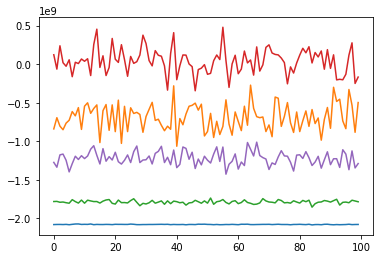

In [216]:
centroids = k_means.cluster_centers_

plt.plot(centroids.T)

In [217]:
def assign_cluster(centroid_list, dic):
    """
    Assigns each review to a cluster.
    
    Args:
        centroid_list: List of centroids in their vector format.
        dic: Dictionary of signatures of reviews.
    Returns:
        assignments: Dictionary of reviews and their cluster.
    """
    assignments = {}
    for ix, sig in enumerate(list(dic.items())):
        distances = []
        for j, centroid in enumerate(centroid_list):
            distances.append(np.linalg.norm(centroid-sig[1]))
        assignments[ix] = np.argmin(distances)
    return assignments

In [218]:
assigned = assign_cluster(centroids, sigs)

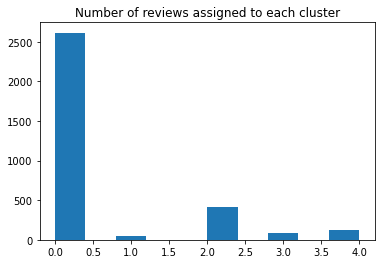

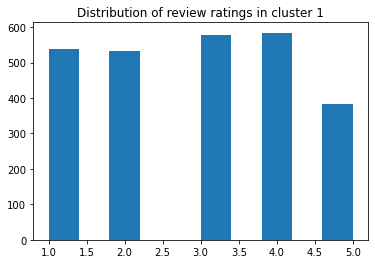

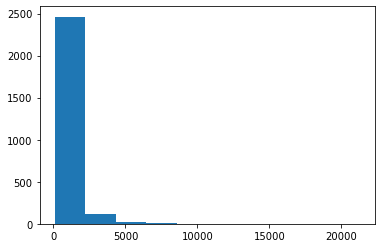

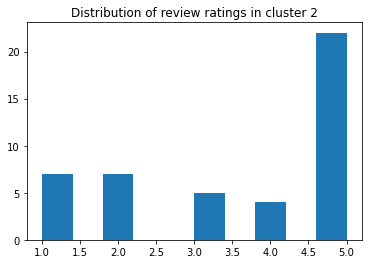

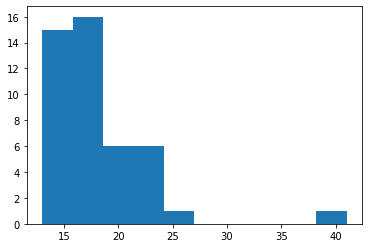

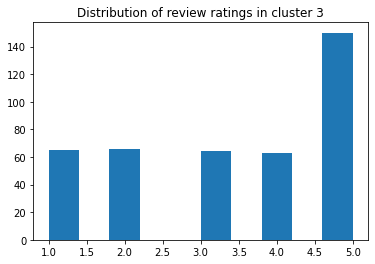

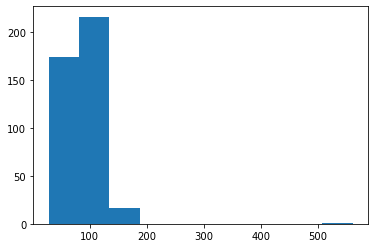

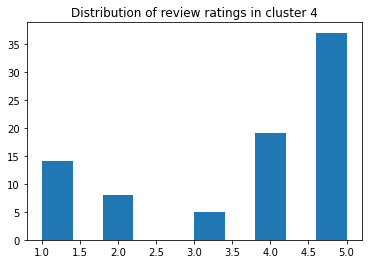

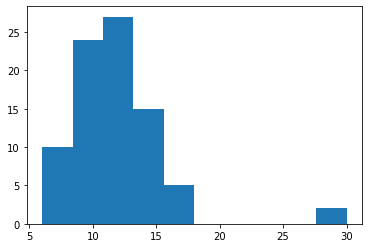

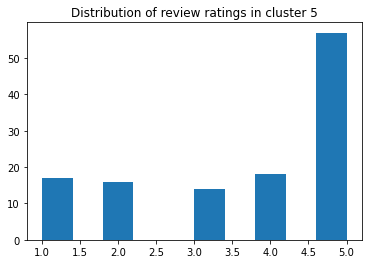

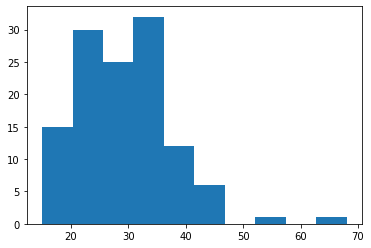

In [219]:
plt.hist(list(assigned.values()))
plt.title("Number of reviews assigned to each cluster")
plt.show()
for i in range(len(centroids)):
    df_slice = df.loc[pd.Series(list(assigned.values())) == i]
    review_lengths = [len(df_slice.Clean_Review.values[i]) for i in range(len(df_slice.Clean_Review.values))]
    plt.hist(df_slice['overall'])
    plt.title(str("Distribution of review ratings in cluster "+ str(i+1)))
    plt.show()
    #plt.hist(review_lengths)
    #plt.show()

In [256]:
from collections import Counter

def calculate_word_frequency(review):
    # Use Counter to count the frequency of each word
    word_freq = Counter(review)
    
    return word_freq

def get_tf_idf(df_docs):
    documents = np.array(df_docs.Clean_Review.values)
    
    N = len(documents)
    
    all_words = {}
    
    # Get number of document appearances for all words:
    for i in range(N):
        text = documents[i].split(" ")
        unique_words = np.unique(text)
        
        for word in unique_words:
            if word not in all_words.keys():
                all_words[word] = 1
            else:
                all_words[word] = all_words[word] + 1
    
    tf_idf = {}
    
    for i in range(N):
        text = documents[i].split(" ")
        word_freq = calculate_word_frequency(text)
        max_freq = max(word_freq.values())
        tf_doc = {}
        for word in word_freq.items():
            tf_doc[word[0]] = word[1]/max_freq*np.log2(N/all_words[word[0]])
        tf_idf[i] = tf_doc
    
    return tf_idf

        

In [257]:
tf_idf = get_tf_idf(df)

In [258]:
tf_idf

{0: {'poor': 5.486132474061732,
  'operating': 5.975517314800657,
  'system': 2.554423515601717,
  'microsoft': 2.881541166591643,
  'ever': 3.8304669819973736,
  'make': 1.751144529335968,
  'long': 3.1175363196730843,
  'boot': 4.94803657837855,
  'time': 1.599141435890918,
  'massive': 7.506032031499436,
  'ram': 4.609867842483976,
  'disc': 5.121368181264112,
  'space': 4.609867842483976,
  'require': 3.781139269633805,
  'use': 0.7758449699642923,
  'window': 2.329443299776113,
  'instead': 3.817976037814177},
 1: {'currently': 0.7152200903193592,
  'use': 0.5818837274732193,
  'quicken': 4.076044190754621,
  'version': 1.3000818957018816,
  'window': 0.29118041247201415,
  'xp': 0.44789998650273705,
  'pro': 0.4159036098388339,
  'display': 4.1600055119975865,
  'resolution': 0.8344946291177187,
  'user': 0.5308219838568693,
  'since': 0.33239359315689937,
  'do': 0.4420507100678694,
  'download': 0.3561760682063542,
  'bank': 0.6583207621005058,
  'stock': 0.765171022658014,
  '

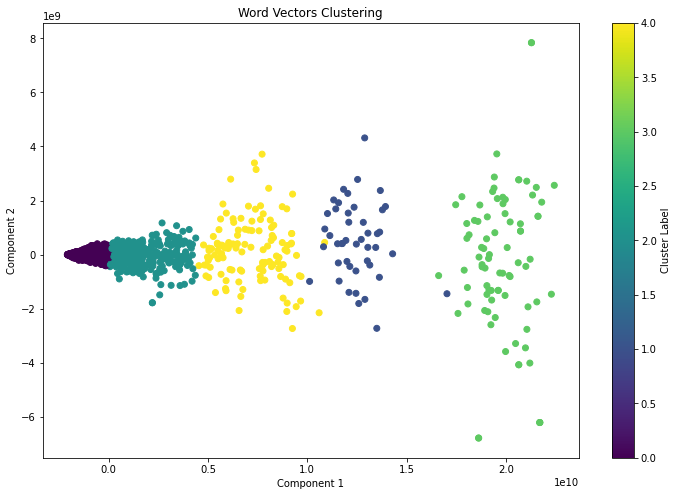

In [227]:
from sklearn.decomposition import PCA

labels = k_means.labels_

pca = PCA(n_components=4)
reduced_X = pca.fit_transform(X)
plt.figure(figsize=(12, 8))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Word Vectors Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
file = "cluster_100_2_2.dat"
filepath = Path.cwd() / 'Data' / file
n, d, points = load_dat(filepath)


## The (naíve) k-means algorithm for 2D data and 2 cluster

# Step 0: Initialisation
# lets do the most basic initialisation 
# where points are picked at random

idx = np.random.randint(len(points), size=2)
representative_1, representative_2 = points[idx, :]

cluster_1 = [representative_1]
cluster_2 = [representative_2]
labels = []

def centroid(cluster_i):
    return np.sum(cluster_i, axis=0) / len(cluster_i)

# (Re)assign each data point p to the cluster C_i
# for which the distance between p and the centroid
# of C_i
for p in points:
    
    # lets use euclidean distance
    d_1 = np.sqrt(np.sum(np.square(centroid(cluster_1) - p)))
    d_2 = np.sqrt(np.sum(np.square(centroid(cluster_2) - p)))
    
    if d_1 < d_2:
        cluster_1.append(p)
        labels.append(1)
    else:
        cluster_2.append(p)
        labels.append(2)
        
plt.scatter(points[:, 0], points[:, 1], c=labels)
plt.show()